In [1]:
# 几个用来绘制灰度和 RGB 图像的函数
def plot_image(image):
    # "nearest" 分辨率不匹配时,只显示图像而不尝试在像素之间进行插值
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")


def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from functools import partial


def initialization():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

In [3]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='../Fonts/SourceHanSerifSC-Medium.otf', size=12)

# CNN架构 CNN Architectures

<img src="../images/other/14-6.png" width="500">

##  VGGNet

### 原理

`VGGNet`有一个非常简单和经典的架构，有 2 或 3 个卷积层和一个池化层，然后又是 2 或 3 个卷积层和一个池化层，依此类推（总共只有 16 或 19 个卷积层，具体取决于VGG 变体），加上具有 2 个隐藏层和输出层的最终密集网络。它只使用了 3 × 3 个过滤器，但使用了许多过滤器。

网络中的亮点: 通过堆叠多个3x3的卷积核来**替代**大尺度卷积核（减少所需参数）→ **拥有相同的感受野**

- 论文中提到，可以通过堆叠两个3x3的卷积核替代5x5的卷积核，堆叠三个3x3的卷积核替代7x7的卷积核。

> **CNN感受野:**
- 在卷积神经网络中，决定某一层输出结果中一个元素所对应的输入层的区域大小，被称作感受野。通俗的解释是，输出特征图上的一个单元对应输入层上的区域大小。
<img src="../images/other/14-24.png" width="600">
- 感受野计算公式：$F (i) = [ F (i + 1) - 1] × Stride + Ksize$
- 例:堆叠三个3x3的卷积核替代7x7的卷积核
    - 特征图: $F(4) = 1$
    - $Conv3×3(3): F(3) = (1-1) × 1 + 3 = 3$
    - $Conv3×3(2): F(2) = (3-1) × 1 + 3 = 5$
    - $Conv3×3(1): F(1) = (5-1) × 1 + 3 = 7$

使用7x7卷积核所需参数，与堆叠三个3x3卷积核所需参数(假设输入输出channel为$C$):
> - 卷积层的权重可以表示为$[f_h,f_w,f_{n^{'}},f_n]$的4D张量
    - $f_h,f_w$表示接受野的高度和宽度
    - $f_{n^{'}},f_n$表示上一层中特征图个数和这一层中特征图个数

- $7 × 7 × C × C = 49C^2 $
- $3 × 3 × C × C + 3 × 3 × C × C + 3 × 3 × C × C = 27C^2 $

网络中所需参数大为减少.

- `VGG16`的网络结构

    原论文中分别使用了A、A-LRN、B、C、D、E这6种网络结构进行测试，这6种网络结构相似，都是由5层卷积层、3层全连接层组成，其中区别在于每个卷积层的子层数量不同，从A至E依次增加（子层数量从1到4），总的网络深度从11层到19层（添加的层以粗体显示），表格中的卷积层参数表示为`conv(感受野大小)-通道数`，例如`conv3-128`，表示使用3x3的卷积核，通道数为128。其中，网络结构D就是著名的`VGG16`，网络结构E就是著名的`VGG19`。

<img src="../images/other/14-27.png">

1. 输入像素为224×224×3的图片，经64个3×3的卷积核作两次卷积+ReLU，卷积后的尺寸变为224×224×64
   - $\frac{224-3+2×1}{1}+1=224$
2. 作max pooling（最大化池化），池化单元尺寸为2x2（效果为图像尺寸减半），池化后的尺寸变为112x112x64
    - $\frac{224-2}{2}+1=112$
3. 经128个3x3的卷积核作两次卷积+ReLU，尺寸变为112x112x128
4. 作2x2的max pooling池化，尺寸变为56x56x128
5. 经256个3x3的卷积核作三次卷积+ReLU，尺寸变为56x56x256
6. 作2x2的max pooling池化，尺寸变为28x28x256
7. 经512个3x3的卷积核作三次卷积+ReLU，尺寸变为28x28x512
8. 作2x2的max pooling池化，尺寸变为14x14x512
9. 经512个3x3的卷积核作三次卷积+ReLU，尺寸变为14x14x512
10. 作2x2的max pooling池化，尺寸变为7x7x512
11. 与两层1x1x4096，一层1x1x1000进行全连接+ReLU（共三层）
    - 卷积层和全连接层的唯一区别就是卷积层的神经元和输入是局部联系的，并且同一个通道（channel）内的不同神经元共享权值（weight）。卷积层和全连接层的计算实际上相同，因此可以将全连接层转换为卷积层，只要将卷积核大小设置为输入空间大小即可：例如输入为7x7x512，第一层全连接层输出4096；我们可以将其看作卷积核大小为7x7，步长为1，没有填充，输出为1x1x4096的卷积层。这样的好处在于输入图像的大小不再受限制，因此可以高效地对图像作滑动窗式预测；而且全连接层的计算量比较大，等效卷积层的计算量减小了，这样既达到了目的又十分高效。
    - 虽然 `VGGNet` 减少了卷积层参数，但实际上其参数空间比 `AlexNet` 大，其中**绝大多数的参数都是来自于第一个全连接层**，耗费更多计算资源。在随后的 NIN 中发现将这些全连接层替换为全局平均池化，对于性能影响不大，同时显著降低了参数数量。
12. 在FC层中间采用dropout层，防止过拟合
<img src="../images/other/14-28.png" width="400">
12. 通过softmax输出1000个预测结果

### `VGG16`演示

In [2]:
initialization()

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Softmax
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.layers.merge import concatenate

In [4]:
# 根据论文所给信息,定义参数配置字典
cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [5]:
# 提取特征信息
def make_feature(cfg):
    feature_layers = []
    for i in cfg:
        if i == "M":
            MaxPooling_layer = MaxPooling2D(pool_size=2, strides=2)
            feature_layers.append(MaxPooling_layer)
        else:
            Conv2D_layer = Conv2D(filters=i, kernel_size=3, padding="SAME",
                                  activation=keras.activations.relu,
                                  kernel_regularizer=l2(0.01))
            feature_layers.append(Conv2D_layer)
    return keras.models.Sequential(feature_layers, name='feature')

- 分类网络结构

In [6]:
def VGG_model(feature, height=224, width=224, num_classes=1000):
    # num_classes 标签的类别数量
    input = Input(shape=(height, width, 3))
    x = feature(input)
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(2048, activation=keras.activations.relu)(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(2048, activation=keras.activations.relu)(x)

    x = Dense(num_classes)(x)
    output = Softmax()(x)
    model = Model(inputs=input, outputs=output)
    return model

In [7]:
def VGG(model_name="vgg16", height=224, width=224, num_classes=1000):
    assert model_name in cfgs.keys(), "not support model {}".format(model_name)
    cfg = cfgs[model_name]
    model = VGG_model(make_feature(cfg), height, width, num_classes)
    return model

2. 查看`VGG16`模型结构

In [8]:
model = VGG('vgg16', 224, 224, 10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
feature (Sequential)         (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              419635

2022-01-07 01:52:32.269713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 01:52:32.362117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 01:52:32.362813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 01:52:32.363920: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

3. 加载,预处理数据集

如果使用`迁移学习`,需要在图像预处理部分减去`ImageNet`所有图像的均值,即**\[123.68, 116.78, 103.94\]**

In [9]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("Cifar10", as_supervised=True, with_info=True)

class_names = info.features["label"].names
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

2022-01-07 01:52:36.513282: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [10]:
train_set_raw = tfds.load("Cifar10", as_supervised=True)['train']
test_set_raw, valid_set_raw = tfds.load("Cifar10",
                                        split=["test[:60%]", "test[60%:]"],
                                        as_supervised=True)

In [11]:
from keras.utils import np_utils


# 预处理
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    label = tf.cast(label, dtype=tf.int32)
    label = tf.squeeze(label)  # tf.squeeze():用于从张量形状中移除大小为1的维度
    label = tf.one_hot(label, depth=10)
    return resized_image, label


batch_size = 64
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [12]:
root_logdir = os.path.join(os.curdir, "../Logs/my_VGG16_logs")
root_logdir


def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


run_dir = get_run_logdir()
run_dir

tensorboard_cb = keras.callbacks.TensorBoard(run_dir)

2022-01-07 01:53:50.560270: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-07 01:53:50.560316: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-07 01:53:50.562249: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-01-07 01:53:50.724974: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-07 01:53:50.725183: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


4. 训练,评估模型

In [13]:
# 编译模型
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
#                                  nesterov=True, decay=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
# 训练模型
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='../my_VGG16.h5',
                                       save_best_only=True,
                                       ave_weights_only=True,
                                       monitor='val_loss'), tensorboard_cb
]

history = model.fit(train_set,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.4 * test_size / batch_size),
                    epochs=100,
                    callbacks=callbacks)

2022-01-07 01:53:51.002454: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-07 01:53:53.226285: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/781 [..............................] - ETA: 3:10:07 - loss: 41.1680 - accuracy: 0.0312

2022-01-07 01:54:05.687535: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-07 01:54:05.687581: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/781 [..............................] - ETA: 8:57 - loss: 41.0604 - accuracy: 0.0625   

2022-01-07 01:54:06.348091: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-07 01:54:06.348930: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-07 01:54:06.486377: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 465 callback api events and 462 activity events. 
2022-01-07 01:54:06.499134: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-07 01:54:06.529352: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ././Logs/my_VGG16_logs/run_2022_01_07-01_53_50/train/plugins/profile/2022_01_07_01_54_06

2022-01-07 01:54:06.542802: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ././Logs/my_VGG16_logs/run_2022_01_07-01_53_50/train/plugins/profile/2022_01_07_01_54_06/401e1ed6a6d0.trace.json.gz
2022-01-07 01:54:06.576298: I tensorfl

781/781 [==============================] - 323s 395ms/step - loss: 9.1317 - accuracy: 0.3216 - val_loss: 2.8247 - val_accuracy: 0.4370
Epoch 2/100
781/781 [==============================] - 312s 399ms/step - loss: 2.4039 - accuracy: 0.4757 - val_loss: 2.1120 - val_accuracy: 0.5171
Epoch 3/100
781/781 [==============================] - 308s 395ms/step - loss: 1.9207 - accuracy: 0.5545 - val_loss: 1.8013 - val_accuracy: 0.5776
Epoch 4/100
781/781 [==============================] - 312s 399ms/step - loss: 1.6505 - accuracy: 0.6099 - val_loss: 1.5500 - val_accuracy: 0.6343
Epoch 5/100
781/781 [==============================] - 312s 399ms/step - loss: 1.4521 - accuracy: 0.6582 - val_loss: 1.4200 - val_accuracy: 0.6595
Epoch 6/100
781/781 [==============================] - 309s 395ms/step - loss: 1.2970 - accuracy: 0.6944 - val_loss: 1.3291 - val_accuracy: 0.6746
Epoch 7/100
781/781 [==============================] - 312s 400ms/step - loss: 1.1756 - accuracy: 0.7261 - val_loss: 1.2307 - val_

In [14]:
model = keras.models.load_model("../my_VGG16.h5")
model.evaluate(test_set)

94/94 [==============================] - 15s 151ms/step - loss: 1.0689 - accuracy: 0.7522


[1.068851351737976, 0.7521666884422302]

In [15]:
history_dict = history.history
train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

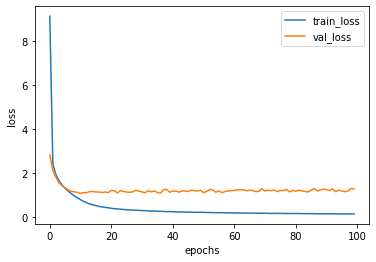

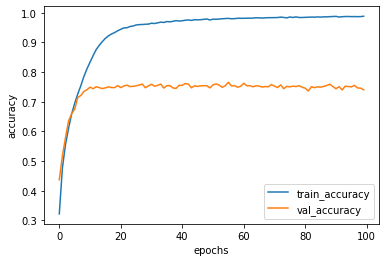

In [16]:
epochs = 100
# figure 1
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# figure 2
plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [4]:
%load_ext tensorboard
%tensorboard --logdir=../Logs/my_VGG16_logs --port=6061

## ResNet

### 原理

- `残差网络 residual Network`所要解决的问题
    1. `梯度消失问题`:反向传播算法中，随着算法向下传播到较低层，梯度通常为越来越小。结果梯度下降更新使较低层的连接权重保持不变，训练不能收敛到一个良好的解。
    2. `退化问题`:在模型的每层中只有少量隐藏单元对不同的输入改变它们的激活值，而大部分隐藏单元对不同输入都是相同反应.使得训练误差和测试误差都很高.

    `残差网络`通过给非线性的卷积层**增加直连边**的方式来提高信息的传播效率.

- 模型原理:

    - 假设在一个深度网络中, 我们期望一个非线性单元$f(\boldsymbol{x} ; \boldsymbol{\theta})$ 去逼近一个目标函数为 $h(\boldsymbol{x})$. 如果将目标函数拆分成两部分: 恒等函数$\boldsymbol{x}$ 和残差函数$h(\boldsymbol{x})-\boldsymbol{x}$.
$$
h(\boldsymbol{x})=\underbrace{\boldsymbol{x}}_{\text {恒等函数 }}+\underbrace{(h(\boldsymbol{x})-\boldsymbol{x})}_{\text {残差函数 }} .
$$
    - 根据通用近似定理, 一个由神经网络构成的非线性单元有足够的能力来近似逼近原始目标函数或残差函数, 但实际中后者更容易学习.

    因此, 原来的优化问题可以转换为: **让非线性单元 $f(\boldsymbol{x} ; \theta)$ 去近似残差函数 $h(\boldsymbol{x})-\boldsymbol{x}$, 并用 $f(\boldsymbol{x} ; \theta)+\boldsymbol{x}$ 去逼近 $h(\boldsymbol{x})$.**
    <img src="../images/other/14-30.png" width="400">

- 网络中的亮点:
    1. 超深的网络结构(突破1000层) 
    2. 提出 `residual模块`
    3. 使用 `Batch Normalization`加速训练(丢弃 `dropout`)

- ResNet架构:
    <img src="../images/other/14-32.png" width="500">
    <img src="../images/other/14-35.png" width="700">

- `residual`模块
    - 主分支与捷径分支的输出特征矩阵shape必须相同
        - `34-layer`: `conv3_x`
            <img src="../images/other/14-37.png">
        - `50-layer`: `conv3_x`
            <img src="../images/other/14-38.png">
            两个1X1卷积层分别用于降低和升高特征维度，主要目的是为了减少参数的数量，从而减少计算量，且在降维之后可以更加有效、直观地进行数据的训练和特征提取,即使它们中间的3×3卷积层的输入和输出的通道数都较小，因此效率更高。
    - 上图中`conv3_x`,`conv4_x`和`conv5_x`指的是各残差结构的第一层残差模块 
        - 对于`18-layer`和`34-layer`: 最大池化下采样后得到的输出为[56,56,64],正好是实线残差结构所需要的输入shape,因此第一层不需要虚线结构
        - 对于`50-layer`,`101-layer`和`152-layer`:最大池化下采样后得到的输出为[56,56,64],而实线残差结构所需要的输入为[56,56,256],因此第一层需要虚线结构,仅用来调整特征矩阵的深度.

- ResNet-50架构:
 <img src="../images/other/14-40.png">

### 批量归一化 Batch Normalization

`批量归一化(Batch Normalization,BN)`方法是一种有效的逐层归一化方法,可以对神经网络中任意的中间层进行归一化操作. 
1. 该操作是对每个输入**零中心化并归一化**;为了使得归一化不对网络的表示能力造成负面影响,可以通过一个附加的**缩放和平移变换**改变取值区间.
2. 批量归一化操作可以看作一个特殊的神经层,加在每一层非线性激活函数前
3. `BN层`添加为第一层的话，通常无需进行归一化训练集

> **批量归一化算法**:
给定一个包含 $K$ 个样本的小批量样本集合, 第 $l$ 层神经元的净输入 $\boldsymbol{z}^{(1, l)}$, $\cdots, \boldsymbol{z}^{(K, l)}$ 的均值和方差为
$$
\begin{aligned}
&\mu_{\mathcal{B}}=\frac{1}{K} \sum_{k=1}^{K} z^{(k, l)} \\
&\sigma_{\mathcal{B}}^{2}=\frac{1}{K} \sum_{k=1}^{K}\left(\boldsymbol{z}^{(k, l)}-\boldsymbol{\mu}_{\mathcal{B}}\right) \odot\left(\boldsymbol{z}^{(k, l)}-\mu_{\mathcal{B}}\right)
\end{aligned}
$$
对净输入 $\boldsymbol{z}^{(l)}$ 的标准归一化会使得其取值集中到 0 附近, 如果使用 Sigmoid 型激活函数时, 这个取值区间刚好是接近线性变换的区间, 减弱了神经网络的非线性性质. 因此, 为了使得归一化不对网络的表示能力造成负面影响, 可以通过 一个附加的缩放和平移变换改变取值区间.
$$
\begin{aligned}
\hat{{z}}^{(l)} &=\frac{\boldsymbol{z}^{(l)}-\boldsymbol{\mu}_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^{2}+\epsilon}} \odot \gamma+\boldsymbol{\beta} \\
& \triangleq \mathrm{B} \mathrm{N}_{\gamma, \beta}\left(\boldsymbol{z}^{(l)}\right)
\end{aligned}
$$
其中 $\gamma$ 和 $\boldsymbol{\beta}$ 分别代表缩放和平移的参数向量. 
批量归一化操作可以看作一个特殊的神经层, 加在每一层非线性激活函数 之前。
$$
\boldsymbol{a}^{(l)}=f\left(\mathrm{BN}_{\gamma, \beta}\left(\boldsymbol{z}^{(l)}\right)\right)=f\left(\mathrm{BN}_{\gamma, \beta}\left(\boldsymbol{W} \boldsymbol{a}^{(l-1)}\right)\right)
$$

4. 当训练完成时, 用 整个数据集上的均值 $\mu$ 和方差 $\sigma$ 来分别代替每次小批量样本的 $\mu_{\mathcal{B}}$ 和方差 $\sigma_{\mathcal{B}}^{2}$. 在实践中, $\mu_{\mathcal{B}}$ 和 $\sigma_{\mathcal{B}}^{2}$ 也可以用**移动平均**来计算.
5.  $\mu_{\mathcal{B}}$ 和 $\sigma_{\mathcal{B}}^{2}$ 计算实例:
<img src="../images/other/14-39.png">
5. 因为批量归一化本身具有平移变换,所以仿射变换${W} {a}^{(l-1)}$不再需要偏置参数.

6. 综上，每个批归一化层学习四个参数向量:
    - 常规反向传播学习:$\gamma$(输出缩放向量),$\beta$(输出偏移向量)
    - 指数平均移动估计:$\mu$(最终输出均值向量),$\sigma$(最终输出标准差向量)
7. 逐层归一化不但可以提高优化效率,还可以作为一种隐形的**正则化方法**. 在训练时, 神经网络对一个样本的预测不仅和该样本自身相关, 也和同一批次中的其他样本相关. 由于在选取批次时具有随机性, 因此使得神经网 络不会“过拟合”到某个特定样本, 从而提高网络的泛化能力.
8. 通过将训练后的`BN层`与上一层融合，从而避免了运行时的损失
10. 训练时要将`traning`参数设置为True，在验证时将`trainning`参数设置为False
11. `batch_size`尽可能设置大点，设置小后表现可能很糟糕，设置的越大求的均值和方差越接近整个训练集的均值和方差。
12.  `BatchNormalization()`的超参数
    - `omentum`:更新指数移动平均值时用到的超参.默认为0.99
    
        给定一个新值$v$(该批次的输入均值或标准差).
    
        更新运行时的平均$\hat{v}$为:
    $$
    \hat{v} \leftarrow  \hat{v}×momentum+v×(1-momentum)
    $$
    𝑚𝑜𝑚𝑒𝑛𝑡𝑢𝑚通常接近于1.
    
    - `axis`:确定那个轴应该被归一化.
    默认为-1,即最后一个轴进行归一化.
    - `epsilon`:即$\epsilon$,防止分母为零

### 迁移学习 Transfer Learning

对于训练非常大型的DNN,我们通常可以找到一个任务类似的神经网络,然后重用该网络的较低层.这被称为`迁移学习`.它会大大加快训练速度,而且会大大减少训练数据.

<img src="../images/other/11-1.png" width="400">

1. 如果新任务的输入图片与原始任务中使用的图片不同,通常需要添加预处理步骤使得其调整为原始模型所需的大小.
2. 通常需要替换掉原始模型的输出层;需要找到正确的层数来重用,任务越相似,可重用的层越多.

用Keras进行迁移学习:查看`第11章 训练深度神经网络(1)-2.1用Keras进行迁移学习`

常见的迁移学习方式：
1. 载入权重后训练所有参数
2. 载入权重后只训练最后几层参数
3. 载入权重后在原网络基础上再添加一层全连接层，仅训练最后一个全连接层

### 使用Keras实现ResNet CNN

In [4]:
initialization()

In [5]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Softmax, BatchNormalization, ReLU, GlobalAvgPool2D, Add, Dropout
from tensorflow.keras.models import Model, Sequential

- ResNet架构:
    <img src="../images/other/14-35.png" width="700">

#### 实现残差结构

-  架构形式应用于`18-layer`和`34-layer`:基础残差模块
    <img src="../images/other/14-37.png">

In [6]:
# 定义残差模块-基本形式
class Residual_Basic(keras.layers.Layer):
    expansion = 1  # 扩展系数  -> 默认不使用虚线结构

    def __init__(self, out_channel, strides=1, downsample=None, **kwargs):
        super(Residual_Basic, self).__init__(**kwargs)
        self.conv1 = Conv2D(filters=out_channel,
                            kernel_size=3,
                            strides=strides,
                            padding="SAME",
                            use_bias=False)
        # 卷积之后，如果要接BN操作，最好是不设置偏置，因为不起作用，
        self.bn1 = BatchNormalization(momentum=0.9, epsilon=1e-5)

        self.conv2 = Conv2D(filters=out_channel,
                            kernel_size=3,
                            strides=1,
                            padding="SAME",
                            use_bias=False)
        self.bn2 = BatchNormalization(momentum=0.9, epsilon=1e-5)
        # down_sample：使用改变特征图大小核深度的跳过连接
        self.downsample = downsample
        self.relu = ReLU()
        self.add = Add()

    def call(self, inputs, training=False):
        # 跳过连接分支
        skip_Z = inputs

        # 使用改变特征图大小核深度的跳过连接分支
        if self.downsample is not None:
            skip_Z = self.downsample(inputs)

        # 主分支
        Z = self.conv1(inputs)
        Z = self.bn1(Z, training=training)
        Z = self.relu(Z)

        Z = self.conv2(Z)
        Z = self.bn2(Z, training=training)

        Z = self.add([Z, skip_Z])
        Z = self.relu(Z)

        return Z

-  架构形式应用于`50-layer`,`101-layer`和`152-layer`:使用瓶颈层的残差模块
    <img src="../images/other/14-38.png" width=700px>

In [7]:
# 定义残差模块-瓶颈层形式
class Residual_Bottleneck(keras.layers.Layer):
    expansion = 4  # 扩展系数

    def __init__(self, out_channel, strides=1, downsample=None, **kwargs):
        super(Residual_Bottleneck, self).__init__(**kwargs)
        # 1×1卷积核:降低特征维度
        self.conv1 = Conv2D(filters=out_channel,
                            kernel_size=1,
                            use_bias=False,
                            name="conv1")
        # 名字用于在迁移学习中与预训练模型的层进行匹配
        self.bn1 = BatchNormalization(momentum=0.9,
                                      epsilon=1e-5,
                                      name="conv1/BatchNorm")

        self.conv2 = Conv2D(filters=out_channel,
                            kernel_size=3,
                            strides=strides,
                            padding="SAME",
                            use_bias=False,
                            name="conv2")
        self.bn2 = BatchNormalization(momentum=0.9,
                                      epsilon=1e-5,
                                      name="conv2/BatchNorm")

        # 1×1卷积核:升高特征维度
        self.conv3 = Conv2D(filters=out_channel * self.expansion,
                            # 64->256  128->512  ...
                            kernel_size=1,
                            use_bias=False,
                            name="conv3")
        self.bn3 = BatchNormalization(momentum=0.9,
                                      epsilon=1e-5,
                                      name="conv3/BatchNorm")
        # down_sample：使用改变特征图大小核深度的跳过连接
        self.downsample = downsample
        self.relu = ReLU()
        self.add = Add()

    def call(self, inputs, training=False):
        # 跳过连接分支
        skip_Z = inputs

        # 使用改变特征图大小核深度的跳过连接分支
        if self.downsample is not None:
            skip_Z = self.downsample(inputs)

        # 主分支
        Z = self.conv1(inputs)
        Z = self.bn1(Z, training=training)
        Z = self.relu(Z)

        Z = self.conv2(Z)
        Z = self.bn2(Z, training=training)
        Z = self.relu(Z)

        Z = self.conv3(Z)
        Z = self.bn3(Z, training=training)

        Z = self.add([Z, skip_Z])
        Z = self.relu(Z)

        return Z

#### 生成一系列的残差结构

In [8]:
def make_conv_x(block, block_num, in_channel, unit1_channel, name, strides=1):
    """
    :param block: 可选择 Residual_Basic 或 Residual_Bottleneck
    :param block_num: 残差结构数量
    :param in_channel: 上一层输出特征矩阵的通道数
    :param unit1_channel: 本残差模块第一个单元的卷积层的的通道数
    """
    # 使用改变特征图大小核深度的跳过连接分支(虚线结构)
    # 1. 当strides大于1时需要：高宽/2,深度加深
    # 2. 对于18和34-layer: 第一层不需要虚线结构
    # 3. 对于50,101和152-layer: 第一层需要虚线结构：调整特征矩阵的深度，高宽不变.
    #                                           ->kernel_size=1
    skipLayer = None
    out_channel = unit1_channel * block.expansion  # conv3_channel
    if (strides != 1) or (in_channel != out_channel):
        skipLayer = Sequential([
            Conv2D(filters=out_channel, kernel_size=1, strides=strides,
                   use_bias=False, name="conv1"),
            BatchNormalization(momentum=0.9, epsilon=1.001e-5, name="BatchNorm")
        ], name="shortcut")  # 跳过层即捷径层

    layersList = []
    # 首先针对第一个单元进行处理
    layersList.append(block(out_channel=unit1_channel, strides=strides,
                            downsample=skipLayer,
                            name="unit_1"))
    # 然后针对其他单元进行处理
    for index in range(1, block_num):  # 3 -> 1, 2
        layersList.append(block(out_channel=unit1_channel, strides=1,
                                downsample=None,
                                name="unit_" + str(index + 1)))

    return Sequential(layersList, name=name)

因为`Conv1`中刚刚对网络输入进行了卷积和最大池化，还没有进行残差学习，此时直接下采样会损失大量信息；而后3个`ConvN_x`直接进行下采样时，前面的网络已经进行过残差学习了，所以可以直接进行下采样。

#### 定义ResNet网络结构

In [9]:
def resnet(block,
           block_num_list,
           height=224,
           width=224,
           num_classes=1000,
           include_top=True):
    """
    :param block: 可选择 Residual_Basic 或 Residual_Bottleneck
    :param block_num_list: 残差结构数量 输入为列表
    :param height: 输入高度像素
    :param width: 输入宽度像素
    :param num_classes:  标签的类别数量
    :param include_top: 
    :return: 
    """
    input = Input(shape=[height, width, 3], dtype="float32")
    # ---------------------
    Z = Conv2D(filters=64,
               kernel_size=7,
               strides=2,
               padding="SAME",
               use_bias=False,
               name="conv1")(input)
    Z = BatchNormalization(momentum=0.9, epsilon=1e-5,
                           name="conv1/BatchNorm")(Z)
    Z = ReLU()(Z)

    Z = MaxPool2D(pool_size=3, strides=2, padding="SAME")(Z)
    # ---------------------
    # 每调用一次make_layer()就生成对应`convN_x`的一系列残差结构
    # Z.shape对应上一层输出特征矩阵的shape对应[batch, height, weight, channel]
    # Z.shape[-1]代表 channel 深度
    Z = make_conv_x(block=block,
                    block_num=block_num_list[0],
                    in_channel=Z.shape[-1],
                    unit1_channel=64,
                    name="block1")(Z)
    Z = make_conv_x(block=block,
                    block_num=block_num_list[1],
                    in_channel=Z.shape[-1],
                    unit1_channel=128,
                    name="block2",
                    strides=2)(Z)
    Z = make_conv_x(block, block_num_list[2], Z.shape[-1], 256, "block3", 2)(Z)
    Z = make_conv_x(block, block_num_list[3], Z.shape[-1], 512, "block4", 2)(Z)
    # ---------------------
    if include_top:  # 不使用迁移学习
        Z = GlobalAvgPool2D()(Z)  # 全局平局池化:结合了pool和flatten的功能
        Z = Dense(units=num_classes, name="logits")(Z)
        predict = Softmax()(Z)
    else:  # 使用迁移学习 可以在后面自定义所需要的层
        predict = Z

    model = Model(inputs=input, outputs=predict)
    return model

#### 定义不同的ResNet架构

In [10]:
# 定义ResNet-18
def resnet18(height=224, width=224, num_classes=1000, include_top=True):
    model = resnet(block=Residual_Basic,
                   block_num_list=[2, 2, 2, 2],
                   height=height,
                   width=width,
                   num_classes=num_classes,
                   include_top=include_top)
    return model

In [11]:
# 定义ResNet-34
def resnet34(height=224, width=224, num_classes=1000, include_top=True):
    model = resnet(Residual_Basic, [3, 4, 6, 3], height, width, num_classes,
                   include_top)
    return model

In [12]:
# 定义ResNet-50
def resnet50(height=224, width=224, num_classes=1000, include_top=True):
    model = resnet(Residual_Bottleneck, [3, 4, 6, 3], height, width,
                   num_classes, include_top)
    return model

In [13]:
# 定义ResNet-101
def resnet101(height=224, width=224, num_classes=1000, include_top=True):
    model = resnet(Residual_Bottleneck, [3, 4, 23, 3], height, width,
                   num_classes, include_top)
    return model

In [14]:
# 定义ResNet-152
def resnet152(height=224, width=224, num_classes=1000, include_top=True):
    model = resnet(Residual_Bottleneck, [3, 8, 36, 3], height, width,
                   num_classes, include_top)
    return model

- 查看`ResNet-34`模型结构

In [16]:
model = resnet34(num_classes=10)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9408      
_________________________________________________________________
conv1/BatchNorm (BatchNormal (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_17 (ReLU)              (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block1 (Sequential)          (None, 56, 56, 64)        222720    
_________________________________________________________________
block2 (Sequential)          (None, 28, 28, 128)       1118

#### 使用迁移学习训练ResNet-50

1. 加载数据集

In [17]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [18]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/Users/jin/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [19]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [20]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [21]:
n_classes = info.features["label"].num_classes
n_classes

5

In [22]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

`tf_flowers`数据集详细信息:https://tensorflow.google.cn/datasets/catalog/tf_flowers


<img src="../images/other/14-52.png" width="500">

2. 拆分数据集

    由于该数据集只有一个`train`数据集,没有验证集和测试集,因此需要拆分数据集.

In [23]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

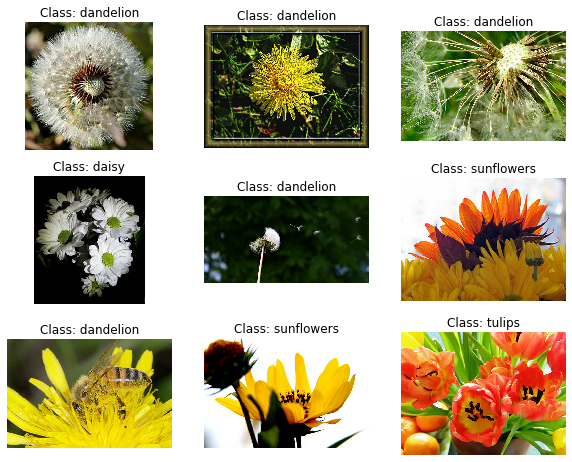

In [24]:
plt.figure(figsize=(10, 8))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

3. 图像预处理

- 基本预处理:对训练集进行乱序，并为所有数据集添加批处理和预取

In [25]:
from keras.utils import np_utils


def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    label = tf.cast(label, dtype=tf.int32)
    label = tf.squeeze(label)  # tf.squeeze():用于从张量形状中移除大小为1的维度
    label = tf.one_hot(label, depth=10)
    return resized_image, label

- 进一步预处理:基本预处理的基础上,执行数据增强,即向训练图像添加一些随机变换

In [26]:
# 中央裁切
def central_crop(image):
    shape = tf.shape(image)  # height, width
    min_dim = tf.reduce_min([shape[0], shape[1]])

    # 从图像左上到右下
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop

    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop

    return image[top_crop:bottom_crop, left_crop:right_crop]

In [27]:
# 随机裁切
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100

    # 如果一个维度不应该被裁剪，则传递该维度的完整大小
    cropped_image = tf.image.random_crop(image, size=[min_dim, min_dim, 3])
    return cropped_image

如果使用`迁移学习`,需要在图像预处理部分减去`ImageNet`所有图像的均值,即**\[123.68, 116.78, 103.94\]** 如果使用别人的预训练模型参数,就必须和別人使用相同的预处理方法!

In [31]:
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

num_classes = 5

In [28]:
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        # random_flip_left_right:随机水平翻转图像（从左到右）。
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)

    resized_image = tf.image.resize(image, [224, 224])
    final_image = resized_image - [_R_MEAN, _G_MEAN, _B_MEAN]
    return final_image, label

In [32]:
batch_size = 16

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(
    preprocess, randomize=True)).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)

test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

2022-01-25 12:00:50.059143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-25 12:00:51.441343: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


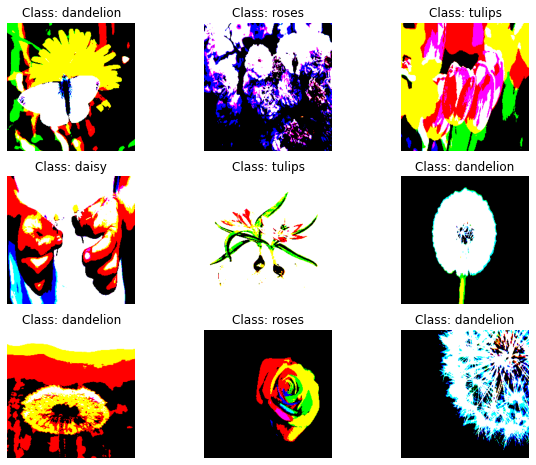

In [14]:
plt.figure(figsize=(10, 8))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index])

        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

4. 使用迁移学习

In [35]:
feature = resnet50(num_classes=num_classes, include_top=False)

In [37]:
# 加载预训练模型的权重
pre_weight_path = '../PTmodel/tf_resnet50_weights/pretrain_weights.ckpt'
feature.load_weights(pre_weight_path)
feature.trainable = False  # 冻结预训练模型的权重参数
feature.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9408      
_________________________________________________________________
conv1/BatchNorm (BatchNormal (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_34 (ReLU)              (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block1 (Sequential)          (None, 56, 56, 256)       218624    
_________________________________________________________________
block2 (Sequential)          (None, 28, 28, 512)       1226

当我们将 `trainable`设置为 `False`时， `feature`的所有权重都会被冻结，训练过程中也无法在训练这些参数.

In [21]:
# 模型最后面添加全连接层
model = Sequential([
    feature,
    GlobalAvgPool2D(),
    Dropout(rate=0.5),
    Dense(1024, activation=keras.activations.relu),
    Dropout(rate=0.5),
    Dense(num_classes),
    Softmax()
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 7, 7, 2048)        23561152  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
_________________________________________________________________
softmax_1 (Softmax)          (None, 10)                0

5. 训练,评估模型

In [19]:
# 编译模型
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
# 训练模型
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=25)

Epoch 1/25


2022-01-25 12:01:00.904045: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


172/172 [==============================] - 19s 54ms/step - loss: 0.9102 - accuracy: 0.6951 - val_loss: 0.4170 - val_accuracy: 0.8603
Epoch 2/25
172/172 [==============================] - 7s 38ms/step - loss: 0.4956 - accuracy: 0.8201 - val_loss: 0.3629 - val_accuracy: 0.8824
Epoch 3/25
172/172 [==============================] - 7s 38ms/step - loss: 0.3999 - accuracy: 0.8576 - val_loss: 0.3611 - val_accuracy: 0.8971
Epoch 4/25
172/172 [==============================] - 7s 38ms/step - loss: 0.3581 - accuracy: 0.8728 - val_loss: 0.3393 - val_accuracy: 0.8934
Epoch 5/25
172/172 [==============================] - 7s 38ms/step - loss: 0.3155 - accuracy: 0.8917 - val_loss: 0.3286 - val_accuracy: 0.8879
Epoch 6/25
172/172 [==============================] - 7s 39ms/step - loss: 0.2912 - accuracy: 0.8979 - val_loss: 0.3153 - val_accuracy: 0.8915
Epoch 7/25
172/172 [==============================] - 7s 38ms/step - loss: 0.2806 - accuracy: 0.8964 - val_loss: 0.3292 - val_accuracy: 0.8971
Epoch 8/2

In [20]:
model.save("my_ResNet50.ckpt")

2022-01-25 12:04:31.444837: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
model = keras.models.load_model("../models/my_ResNet50.ckpt")
model.evaluate(test_set)

23/23 [==============================] - 2s 50ms/step - loss: 0.2672 - accuracy: 0.9183


[0.26717084646224976, 0.9182561039924622]

In [22]:
history_dict = history.history
train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

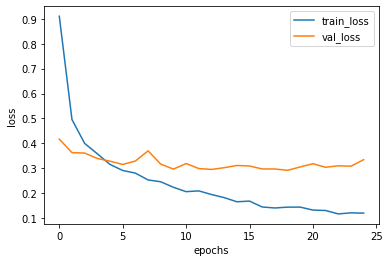

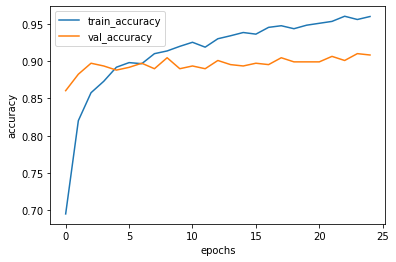

In [23]:
epochs = 25
# figure 1
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# figure 2
plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

### 使用Keras的预训练模型 Using Pretrained Models from Keras

1. 获取预训练模型
    
    通常，您不必手动实现像 `GoogLeNet` 或 `ResNet` 这样的标准模型，因为预训练的网络可以通过 `keras.applications` 包中获得。

In [4]:
# 创建一个ResNet-50模型并下载ImageNet数据集上预训练的权重
model = keras.applications.resnet50.ResNet50(weights="imagenet")
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

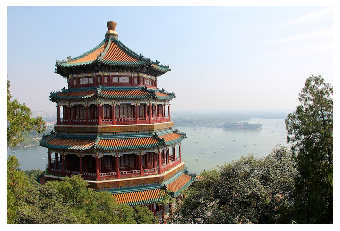

In [5]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255.0
flower = load_sample_image("flower.jpg") / 255.0
images = np.array([china, flower])

plot_color_image(images[0])

2. 调整图像的大小

    要使用它，首先需要确保图像具有正确的大小。 `ResNet-50` 模型需要 224 × 224 像素的图像.

    使用`tf.image.resize()`函数来调整我们之前加载的图像的大小

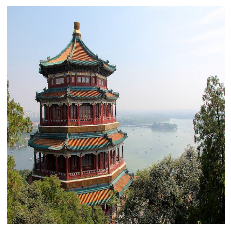

In [6]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])

`tf.image.resize() `不保留宽高比,可以使用

- `tf.image.resize_with_pad()`:调整图像大小并将图像**填充**到目标宽度和高度。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


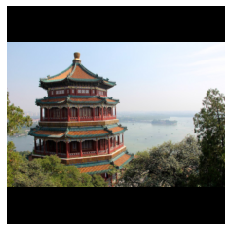

In [7]:
images_resized = tf.image.resize_with_pad(image=images,
                                          target_height=224,
                                          target_width=224,
                                          antialias=True)  # 抗锯齿
plot_color_image(images_resized[0])

- `tf.image.resize_with_crop_or_pad()`:将图像**裁剪**/填充到目标宽度和高度。

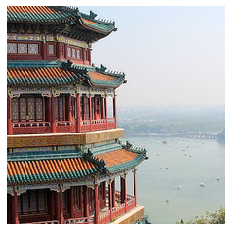

In [8]:
images_resized = tf.image.resize_with_crop_or_pad(image=images,
                                                  target_height=224,
                                                  target_width=224)
plot_color_image(images_resized[0])

- `tf.image.crop_amd_resize()`:同时实现图像裁剪为适当宽高比和调整尺寸的操作.
```python
tf.image.crop_and_resize(
    image,     
    boxes,
    box_ind,
    crop_size,
    method='bilinear',
    extrapolation_value=0,
    name=None
)
```

    1. `image`:一个四维的张量,输入格式为`[batch, image_height, image_width, depth].`
    2. `boxes`:指需要划分的区域位置的百分比，输入格式为 `[[ymin,xmin,ymax,xmax]]` ,设crop的区域坐标为 `[ y1,x1,y2,x2 ]`,那么想得到相应正确的crop图形就一定要**归一化**，即图片长度为 [ W,H ],则实际输入的boxes为 [ $\frac{y_1}{H}$,$\frac{x_1}{W}$,$\frac{y_2}{H}$,$\frac{x_2}{W}$ ]。
        - 情况一:不超出1
        - 情况二:超出1--自动补齐,当全部超出1，那就是个黑色框了，因为超出1根据归一化截取不到图片任何内容.
    3. `box_ind`:用于索引
    4. `crop_size`:图像裁剪大小

        例:图像高度=427 , 图像宽度=640, 经过标准化后图像($\frac{427}{255.0}$,$\frac{640}{255.0}$).框选范围位置的百分比为`[0, 0.03, 1, 0.68]`,
            得 [ 0*427=0, 0.03*640=19.2, 1*427=427, 0.68*640=435.2 ],
        调整大小到`[224,224]`

In [9]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]

images_resized = tf.image.crop_and_resize(image=images,
                                          boxes=[china_box, flower_box],
                                          box_indices=[0, 1],
                                          crop_size=[224, 224])

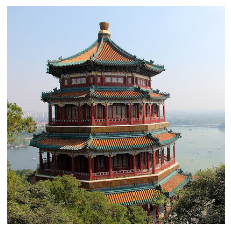

In [10]:
plot_color_image(images_resized[0])

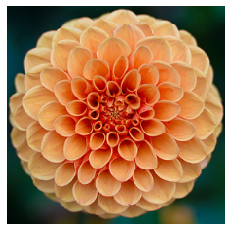

In [11]:
plot_color_image(images_resized[1])

3. 根据预训练模型来预处理图像
   
   每个模型都提供了一个 `preprocess_input()` 函数，可以使用它来预处理您的图像。**这些函数假定像素值的范围是 0 到 255**，由于之前的工作我们实现了归一化,因此我们必须将它们乘以 255.

In [12]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

4. 预测
    
    输出 `y_proba` 是一个矩阵，每幅图像一行，每类一列。
    
    如果要显示前 K 个预测(包括类名和每个预测类的估计概率)使用 `decode_predictions()`。对于每个图像，它返回一个包含前 K 个预测的数组，其中每个预测都表示为一个**包含类标识符**（在 `ImageNet` 数据集中，每个图像都与 `WordNet `数据集中的一个词相关联：类ID是一个`WordNetID`）,它的名称，以及相应的置信度分数的数组.

In [13]:
y_proba = model.predict(inputs)
np.shape(y_proba)

(2, 1000)

In [14]:
top_K = keras.applications.resnet50.decode_predictions(y_proba, top=3)

for image_index in range(len(images)):  # 0,1
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



## Xception

### 原理

谷歌`Xception`，将`深度可分离卷积`引入`Inception模块`，实现长宽方向的空间信息和跨通道信息的完全解耦。X代表Extreme，极致。

在ImageNet数据集和JFT数据集两个大规模图像分类任务上，收敛速度、最终准确率都超过`Inception V3`。

`Xception`作者为深度学习框架Keras作者François Chollet。在Keras中可调用预训练的`Xception`模型作为迁移学习的骨干网络。

- `深度可分离卷积`分为两个部分:
    - 为每个输入特征图应用一个空间过滤器(每个通道一个)
    - 专门寻找夸通道模式-具有1×1卷积核的常规卷积层

    <img src="../images/other/14-42.png" width="500">
    <img src="../images/other/14-44.png">
    
    与常规卷积层相比，`可分离卷积层`使用更少的参数、更少的内存和更少的计算量，而且通常它们甚至表现得更好.
由于可分离卷积层每个输入通道只有一个空间滤波器，因此应避免在通道太少的层（例如输入层）之后使用它们.

    因此，`Xception` 架构从 2 个常规卷积层开始，但随后架构的其余部分仅使用可分离卷积（总共 34 个），加上几个最大池化层和通常的最终层（一个全局平均池化层和一个密集输出层）。



- `Xception`中改进的`深度可分离卷积`与原始`深度可分离卷积`区别：
    1. 在于操作顺序不同：先进行 `Pointwise` 再 `Depthwise` 
    2. 激活函数： `Pointwise` 之后 `Depthwise` 之前，**不使用激活函数效果最好**
    
    <img src="../images/other/14-45.png">

- 整体架构
    <img src="../images/other/14-46.png">

- keras源码

In [15]:
import tensorflow.compat.v2 as tf

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils
from tensorflow.python.util.tf_export import keras_export

layers = VersionAwareLayers()


def Xception(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             classifier_activation='softmax'):

    # 确定正确的输入形状
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=71,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1

    # Entry flow
    x = layers.Conv2D(32, (3, 3),
                      strides=(2, 2),
                      use_bias=False,
                      name='block1_conv1')(img_input)
    x = layers.BatchNormalization(axis=channel_axis, name='block1_conv1_bn')(x)
    x = layers.Activation('relu', name='block1_conv1_act')(x)
    x = layers.Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block1_conv2_bn')(x)
    x = layers.Activation('relu', name='block1_conv2_act')(x)

    residual = layers.Conv2D(128, (1, 1),
                             strides=(2, 2),
                             padding='same',
                             use_bias=False)(x)
    residual = layers.BatchNormalization(axis=channel_axis)(residual)

    x = layers.SeparableConv2D(128, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block2_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='block2_sepconv1_bn')(x)
    x = layers.Activation('relu', name='block2_sepconv2_act')(x)
    x = layers.SeparableConv2D(128, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block2_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='block2_sepconv2_bn')(x)

    x = layers.MaxPooling2D((3, 3),
                            strides=(2, 2),
                            padding='same',
                            name='block2_pool')(x)
    x = layers.add([x, residual])

    residual = layers.Conv2D(256, (1, 1),
                             strides=(2, 2),
                             padding='same',
                             use_bias=False)(x)
    residual = layers.BatchNormalization(axis=channel_axis)(residual)

    x = layers.Activation('relu', name='block3_sepconv1_act')(x)
    x = layers.SeparableConv2D(256, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block3_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='block3_sepconv1_bn')(x)
    x = layers.Activation('relu', name='block3_sepconv2_act')(x)
    x = layers.SeparableConv2D(256, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block3_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='block3_sepconv2_bn')(x)

    x = layers.MaxPooling2D((3, 3),
                            strides=(2, 2),
                            padding='same',
                            name='block3_pool')(x)
    x = layers.add([x, residual])

    residual = layers.Conv2D(728, (1, 1),
                             strides=(2, 2),
                             padding='same',
                             use_bias=False)(x)
    residual = layers.BatchNormalization(axis=channel_axis)(residual)

    x = layers.Activation('relu', name='block4_sepconv1_act')(x)
    x = layers.SeparableConv2D(728, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block4_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='block4_sepconv1_bn')(x)
    x = layers.Activation('relu', name='block4_sepconv2_act')(x)
    x = layers.SeparableConv2D(728, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block4_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='block4_sepconv2_bn')(x)

    x = layers.MaxPooling2D((3, 3),
                            strides=(2, 2),
                            padding='same',
                            name='block4_pool')(x)
    x = layers.add([x, residual])

    # Middle flow
    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = layers.Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = layers.SeparableConv2D(728, (3, 3),
                                   padding='same',
                                   use_bias=False,
                                   name=prefix + '_sepconv1')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      name=prefix + '_sepconv1_bn')(x)
        x = layers.Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = layers.SeparableConv2D(728, (3, 3),
                                   padding='same',
                                   use_bias=False,
                                   name=prefix + '_sepconv2')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      name=prefix + '_sepconv2_bn')(x)
        x = layers.Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = layers.SeparableConv2D(728, (3, 3),
                                   padding='same',
                                   use_bias=False,
                                   name=prefix + '_sepconv3')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    # Exit flow
    residual = layers.Conv2D(1024, (1, 1),
                             strides=(2, 2),
                             padding='same',
                             use_bias=False)(x)
    residual = layers.BatchNormalization(axis=channel_axis)(residual)

    x = layers.Activation('relu', name='block13_sepconv1_act')(x)
    x = layers.SeparableConv2D(728, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block13_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='block13_sepconv1_bn')(x)
    x = layers.Activation('relu', name='block13_sepconv2_act')(x)
    x = layers.SeparableConv2D(1024, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block13_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='block13_sepconv2_bn')(x)

    x = layers.MaxPooling2D((3, 3),
                            strides=(2, 2),
                            padding='same',
                            name='block13_pool')(x)
    x = layers.add([x, residual])

    x = layers.SeparableConv2D(1536, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block14_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='block14_sepconv1_bn')(x)
    x = layers.Activation('relu', name='block14_sepconv1_act')(x)

    x = layers.SeparableConv2D(2048, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block14_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='block14_sepconv2_bn')(x)
    x = layers.Activation('relu', name='block14_sepconv2_act')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(classes,
                         activation=classifier_activation,
                         name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # 创建模型
    model = training.Model(inputs, x, name='xception')

    return model

### 迁移学习的预训练模型 Pretrained Models for Transfer Learning

如果构建图像分类器但没有足够的训练数据，那么可以重用预训练模型的较低层.

使用预训练`Xception`图像分类

1. 加载数据集

In [4]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [7]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [8]:
n_classes = info.features["label"].num_classes
n_classes

5

In [9]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

2. 拆分数据集

    由于该数据集只有一个`train`数据集,没有验证集和测试集,因此需要拆分数据集.

In [10]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

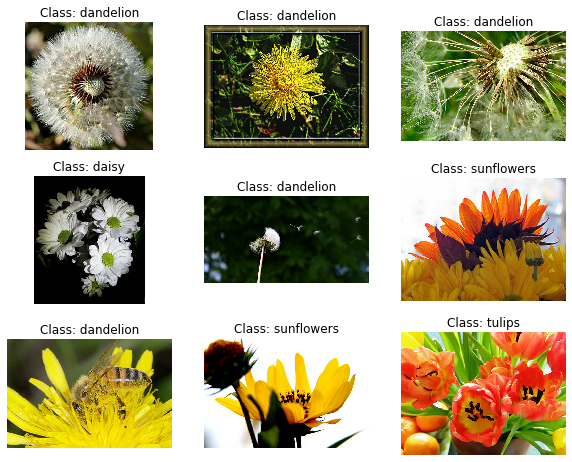

In [11]:
plt.figure(figsize=(10, 8))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

3. 图像预处理

- 基本预处理:对训练集进行乱序，并为所有数据集添加批处理和预取

In [12]:
from keras.utils import np_utils


def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    label = tf.cast(label, dtype=tf.int32)
    label = tf.squeeze(label)  # tf.squeeze():用于从张量形状中移除大小为1的维度
    label = tf.one_hot(label, depth=10)
    return resized_image, label

- 进一步预处理:基本预处理的基础上,执行数据增强,即向训练图像添加一些随机变换

In [13]:
# 中央裁切
def central_crop(image):
    shape = tf.shape(image)  # height, width
    min_dim = tf.reduce_min([shape[0], shape[1]])

    # 从图像左上到右下
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop

    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop

    return image[top_crop:bottom_crop, left_crop:right_crop]

In [14]:
# 随机裁切
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100

    # 如果一个维度不应该被裁剪，则传递该维度的完整大小
    cropped_image = tf.image.random_crop(image, size=[min_dim, min_dim, 3])
    return cropped_image

In [15]:
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        # random_flip_left_right:随机水平翻转图像（从左到右）。
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)

    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [16]:
batch_size = 32

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(
    preprocess, randomize=True)).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)

test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

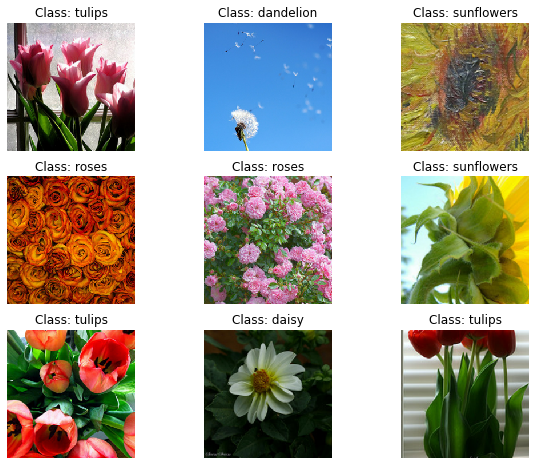

In [17]:
plt.figure(figsize=(10, 8))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)

        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

4. 加载预训练模型
    
    加载在 `ImageNet` 上预训练的` Xception` 模型，
    
    `include_top=False`将不包括全局平均池化层和密集输出层,以用于迁移学习

In [18]:
initialization()

In [19]:
from tensorflow.keras.layers import Dense, Softmax, GlobalAvgPool2D
from tensorflow.keras.models import Model, Sequential

In [20]:
feature = keras.applications.xception.Xception(weights='imagenet',
                                               include_top=False)

In [21]:
model = Sequential([
    feature,
    GlobalAvgPool2D(),
    Dense(n_classes),
    Softmax()
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
_________________________________________________________________
softmax (Softmax)            (None, 5)                 0         
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


5. 冻结预训练权重,并编译训练模型

    在前几个轮次时冻结重用层,给新层一些时间来学习.原因是新的输出层是随机初始化的,存在较大的错误,这会破坏重用的权重.
    
    不同于`1.2.4.5使用迁移学习训练 Resnet-50`加载的预训练模型已经经过了处理,剔除了无关的参数信息.这里所使用的是`feature`的部分层,因此使用`feature.trainable = False `无效.
    
    在前 5 个 epoch 冻结重用层    

In [22]:
for layer in feature.layers:
    layer.trainable = False

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


2022-01-24 06:06:35.088702: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


86/86 [==============================] - 18s 102ms/step - loss: 1.1904 - accuracy: 0.7892 - val_loss: 1.0645 - val_accuracy: 0.8382
Epoch 2/5
86/86 [==============================] - 8s 89ms/step - loss: 0.4923 - accuracy: 0.8968 - val_loss: 0.9263 - val_accuracy: 0.8364
Epoch 3/5
86/86 [==============================] - 8s 89ms/step - loss: 0.3200 - accuracy: 0.9190 - val_loss: 0.7915 - val_accuracy: 0.8640
Epoch 4/5
86/86 [==============================] - 8s 88ms/step - loss: 0.2513 - accuracy: 0.9299 - val_loss: 0.6230 - val_accuracy: 0.8732
Epoch 5/5
86/86 [==============================] - 8s 89ms/step - loss: 0.1853 - accuracy: 0.9466 - val_loss: 0.5692 - val_accuracy: 0.8750


对模型进行几轮的训练之后,验证集上的准确度维持着87%左右,并且不再取得很大的进展.这意味着顶层现在已经受到了良好的训练,因此接下来解冻所有层,并继续进行训练.注意要使用较低的学习率避免损坏训练的权重.

6. 解冻预训练权重,并编译训练模型

In [22]:
for layer in feature.layers:
    layer.trainable = True

In [23]:
optimizer = keras.optimizers.SGD(learning_rate=0.01,
                                 momentum=0.9,
                                 nesterov=True,
                                 decay=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 38s 396ms/step - loss: 0.3484 - accuracy: 0.8884 - val_loss: 0.2582 - val_accuracy: 0.9228
Epoch 2/40
86/86 [==============================] - 34s 390ms/step - loss: 0.1042 - accuracy: 0.9680 - val_loss: 0.2501 - val_accuracy: 0.9062
Epoch 3/40
86/86 [==============================] - 33s 389ms/step - loss: 0.0706 - accuracy: 0.9764 - val_loss: 0.2688 - val_accuracy: 0.9062
Epoch 4/40
86/86 [==============================] - 33s 387ms/step - loss: 0.0741 - accuracy: 0.9771 - val_loss: 0.1961 - val_accuracy: 0.9338
Epoch 5/40
86/86 [==============================] - 33s 386ms/step - loss: 0.0314 - accuracy: 0.9876 - val_loss: 0.2542 - val_accuracy: 0.9136
Epoch 6/40
86/86 [==============================] - 33s 386ms/step - loss: 0.0205 - accuracy: 0.9927 - val_loss: 0.2779 - val_accuracy: 0.9283
Epoch 7/40
86/86 [==============================] - 33s 386ms/step - loss: 0.0302 - accuracy: 0.9895 - val_loss: 0.3494 - val_accuracy: 0.8989

验证集上的准确度达到了约95%的精度.

## SENet

### 原理

在 `ILSVRC 2017` 挑战赛中获胜的架构是 `SE Net`。该架构扩展了现有架构(例如 `inception 网络`和 `ResNets`)并提高了它们的性能。这让 `SENet` 以惊人的 2.25% top-5 错误率赢得了比赛！

`inception网络`和 `ResNet 网络`的扩展版本分别称为 `SE-Inception` 和 `SE-ResNet`。

提升来自于一个事实--即 `SENet` 向原始架构中的每个单元(即每个`inception`模块或每个残差单元)**添加了一个称为 `SE 块`的小型神经网络.**

- `SENet`的主要思想:通过学习的方式来自动获取到每个特征通道的重要程度，然后依照这个重要程度去提升有用的特征并抑制对当前任务用处不大的特征。

`SE块`分析它所连接的单元的输出，只关注深度维度（它不寻找任何空间模式），并了解哪些特征通常是最活跃。然后使用此信息**重新校准特征图.**

例如，`SE块`可能会学习嘴、鼻子和眼睛通常一起出现的图片：如果你看到一个鼻子，您也应该期望看到眼睛。因此，如果块在嘴巴和鼻子特征图中看到强烈的激活，但在眼睛特征图中只有轻微的激活，它将提升眼睛特征图（更准确地说，**它将减少不相关的特征图**）。如果眼睛与其他东西有些混淆，这种特征图重新校准将有助于解决歧义。

<img src="../images/other/14-48.png" width="500">

`SE块`仅由三层组成：`全局平均池化层`、使用`ReLU` 激活函数的隐藏密集层和使用 `sigmoid` 激活函数的密集输出层.

- 模型详解

    <img src="../images/other/14-50.jpg"  width="500">
    
    上图是我们提出的 `SE 模块`的示意图。给定一个输入 $x$，其特征通道数为 $c_1$，通过一系列卷积等一般变换$F_{tr}$后得到一个特征通道数为 $c_2$ 的特征。与传统的 CNN 不一样的是，接下来我们通过三个操作来重标定前面得到的特征。

    1. 首先是 `Squeeze 操作`，我们顺着空间维度来进行特征压缩，**将一个通道中整个空间特征编码为一个全局特征**，这个实数某种程度上具有全局的感受野，并且输出的维度和输入的特征通道数相匹配。它表征着在特征通道上响应的全局分布，而且使得靠近输入的层也可以获得全局的感受野，这一点在很多任务中都是非常有用的。此操作通常采用采用 `global average pooling `来实现。

    2. 得到了全局描述特征后，我们进行 `Excitation 操作`，它是一个类似于循环神经网络中门的机制,用于来抓取特征通道之间的关系。通过参数 $W$ 来为每个特征通道生成权重，其中参数 $W$ 被学习用来显式地建模特征通道间的相关性。
    
    $$
    s=F_{e x}(z, W)=\sigma(g(z, W))=\sigma\left(W_{2} \operatorname{Re} L U\left(W_{1} z\right)\right)
    $$
    
    这里采用包含两个全连接层的 `bottleneck` 结构，即中间小两头大的结构：其中第一个全连接层起到降维的作用，并通过 ReLU 激活，第二个全连接层用来将其恢复至原始的维度。进行 `Excitation 操作`的最终目的是为每个特征通道生成权重，即学习到的各个通道的激活值（sigmoid 激活，值在 0~1 之间）。
    <img src="../images/other/14-49.png" width="200">
    
    3. 最后是一个 `Scale操作`，我们将 `Excitation` 的输出的权重看做是经过特征选择后的每个特征通道的重要性，然后通过乘法逐通道加权到先前的特征上，完成在通道维度上的对原始特征的重标定，从而使得模型对各个通道的特征更有辨别能力，这类似于`attention机制`。

<img src="../images/other/14-47.png" width="400">

上图左侧是`SE-Inception` 模块,右侧是`SE-ResNet`模块.
<img src="../images/other/14-51.jpg"  width="600">

> create:Apotosome 01/25/22

> update:Apotosome 10/26/22